### Import Packages

In [7]:
# These are most of what we need
import math
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

### Let's see what we are dealing with first
We will plot all the images found in the folder

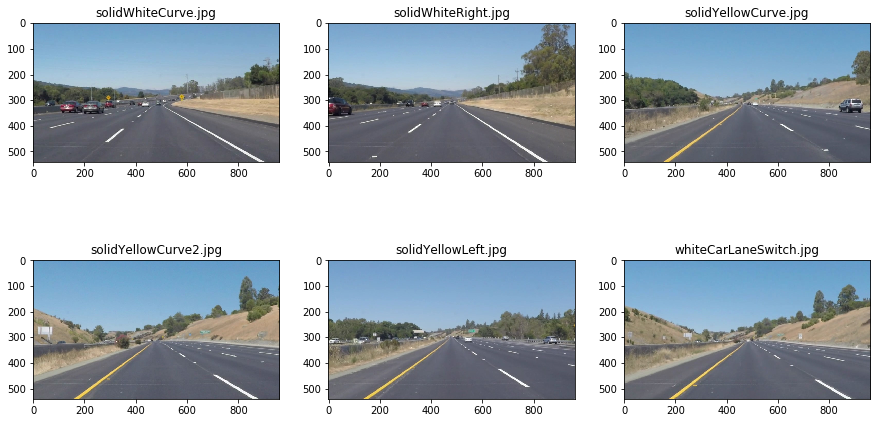

In [16]:
folder_name = 'test_images/'
img_files = os.listdir(folder_name)

fig = plt.figure(figsize=(15,8))
count = len(img_files)
col = 3
row = int(count / col) + (count % col)
item = 0

for file in img_files:
    item += 1
    path = folder_name + file
    img = cv2.imread(path)
    fig.add_subplot(row, col, item)
    plt.title(file)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Inspection
So we have 6 different test images, with either left or right lane as solid line as well as yellow and white in color

### Helper Functions
Some basic help functions

In [82]:
def grayscale(img, dstColor=cv2.COLOR_BGR2GRAY):
    # Default dstColor space is assuming using cv2.imread
    # Use cv2.COLOR_RGB2GRAY if use other
    return cv2.cvtColor(img, dstColor)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by "vertices" with the fill color 
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255,0,0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, thickness=2):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Build a Lane Finding Pipeline

#### Canny Edge
Build a basic lane finding pipeline that will roughly find the lane to start with. First work inspect Canny Edge

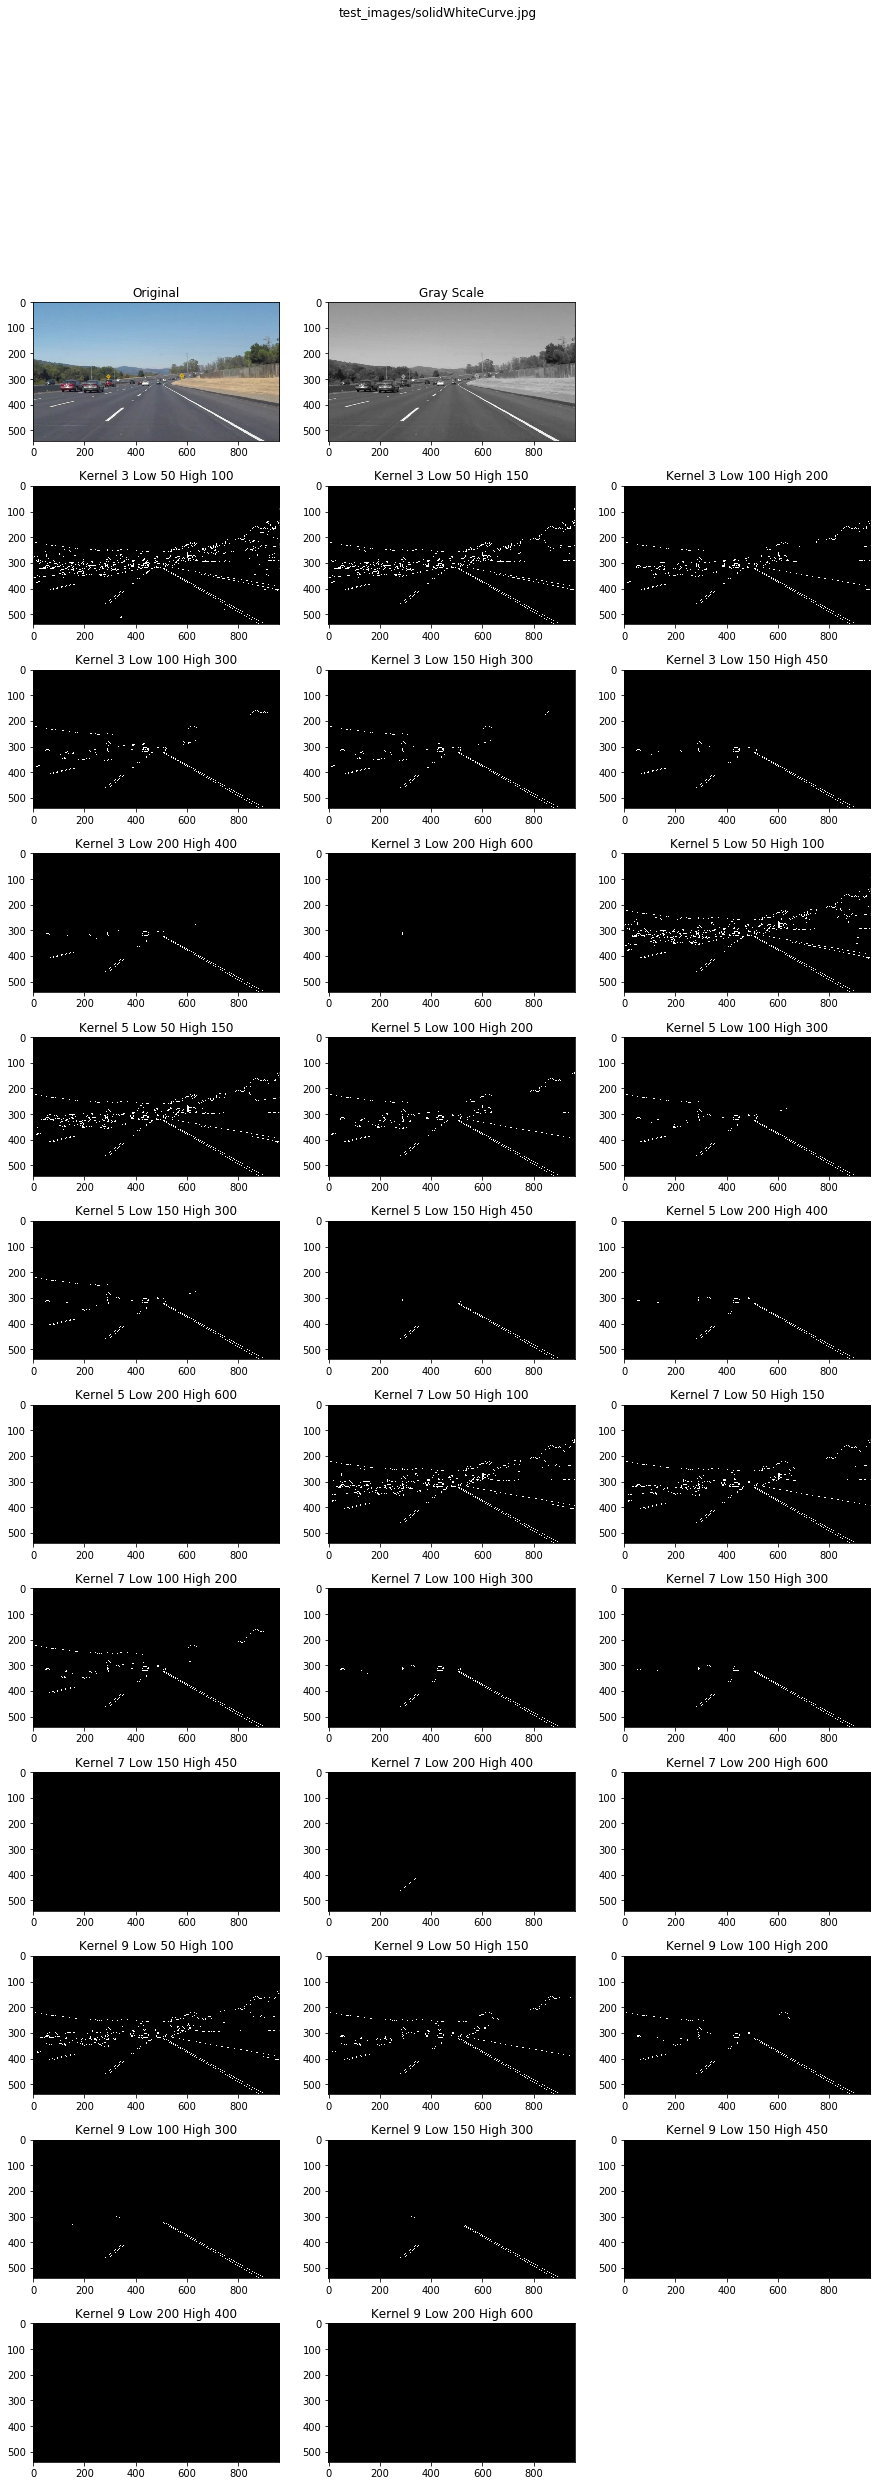

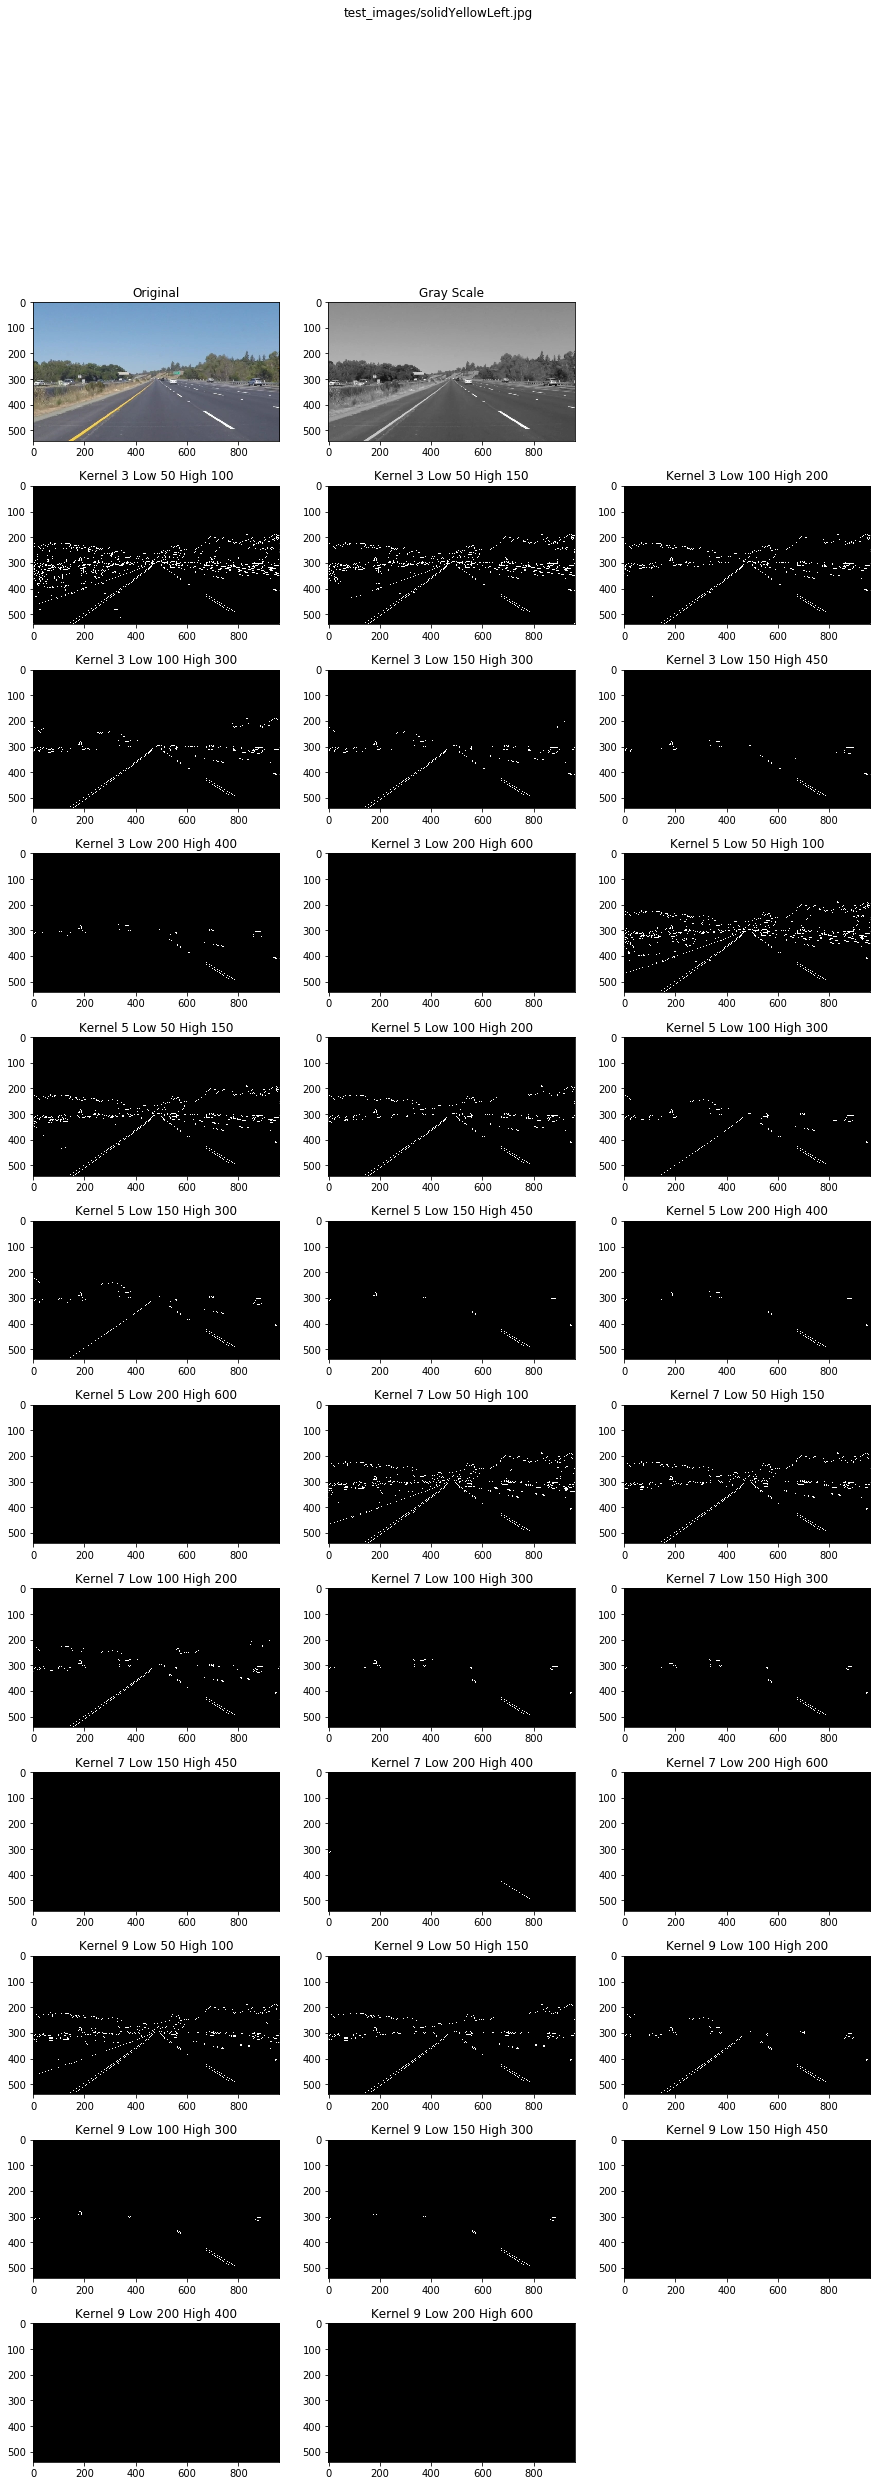

In [46]:
# Try to loop through some different parameter settings and see if there is any good one
def inspect_plot(img_path):
    fig = plt.figure(figsize=(15,40))
    fig.suptitle(img_path, fontsize=12)
    
    col = 3
    row = 12
    count = 0
    
    img = cv2.imread(img_path)
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    gray_img = grayscale(img)
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Gray Scale')
    plt.imshow(gray_img, cmap='gray')
    
    # Skip the 3rd image
    count = 3
    
    base_thresholds = [50,100,150,200]
    
    for k in range(1,5):
        for base in base_thresholds:
            for threshold_ratio in range (2,4): # This will give 1:2 and 1:3
                # Calculate the basic
                kernel_size = 1 + k * 2
                low_threshold = base
                high_threshold = low_threshold * threshold_ratio
                
                # Process it
                blur_img = gaussian_blur(gray_img, kernel_size)
                canny_img = canny(blur_img, low_threshold, high_threshold)
                
                # Plot the result
                count += 1
                fig.add_subplot(row, col, count)
                plt.title('Kernel {} Low {} High {}'.format(kernel_size, low_threshold, high_threshold))
                plt.imshow(canny_img, cmap='gray')
    
img_files = ['solidWhiteCurve.jpg', 'solidYellowLeft.jpg'] # Pick some samples
    
for file in img_files:
    path = folder_name + file
    inspect_plot(path)

Look like the following paramters give a decent result at this stage

* kernel = 5
* low_threshold = 100
* high_threshold = 200

Let's try to run on all test images and see

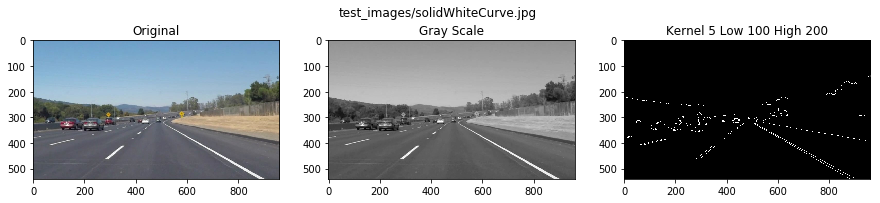

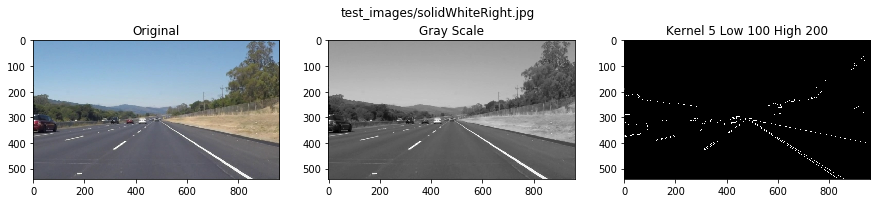

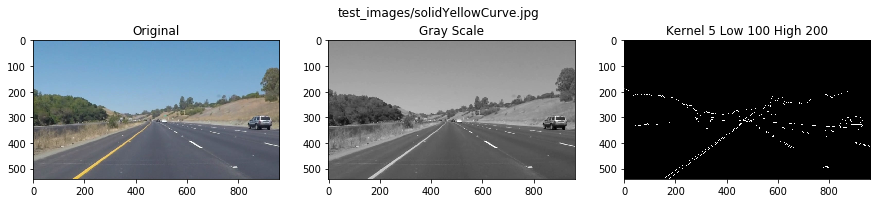

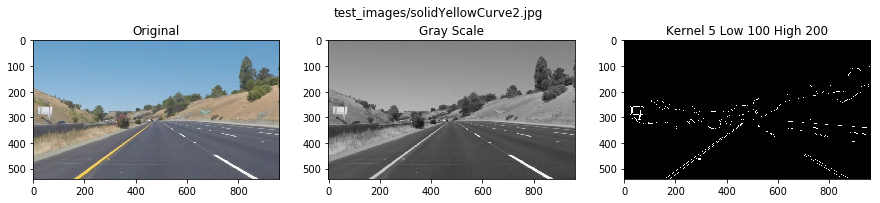

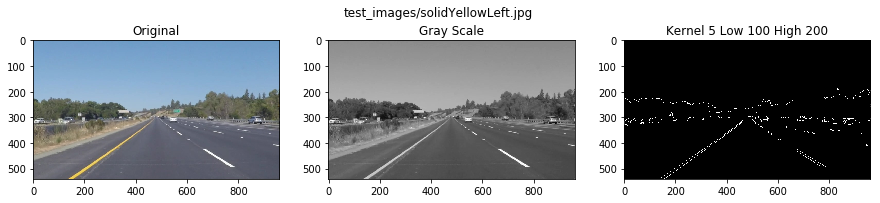

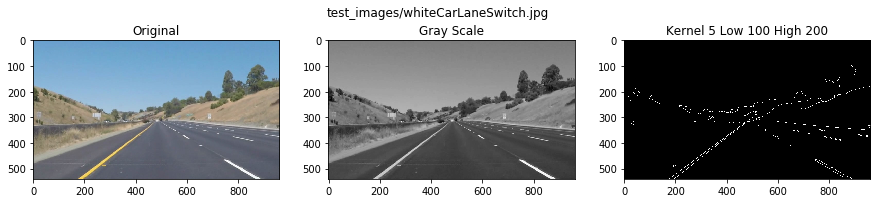

In [57]:
# Try to loop through some different parameter settings and see if there is any good one
def inspect_canny_plot_fixed_parameters(img_path, kernel_size=5, low_threshold=100, high_threshold=200):
    fig = plt.figure(figsize=(15,3))
    fig.suptitle(img_path, fontsize=12)
    
    col = 3
    row = 1
    count = 0
    
    img = cv2.imread(img_path)
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    gray_img = grayscale(img)
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Gray Scale')
    plt.imshow(gray_img, cmap='gray')
    
    # Process it
    blur_img = gaussian_blur(gray_img, kernel_size)
    canny_img = canny(blur_img, low_threshold, high_threshold)

    # Plot the result
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Kernel {} Low {} High {}'.format(kernel_size, low_threshold, high_threshold))
    plt.imshow(canny_img, cmap='gray')
    
# img_files = ['solidWhiteCurve.jpg', 'solidYellowLeft.jpg'] # Pick some samples
img_files = os.listdir(folder_name)

# Define the paramters
kernel_size = 5
low_threshold = 100
high_threshold = 200

for file in img_files:
    path = folder_name + file
    inspect_canny_plot_fixed_parameters(path, kernel_size, low_threshold, high_threshold)

So far so good for Canny Edge on all test images

#### Region of Interest
We don't need everything on the images, let zoom out the area we need

In [56]:
# Since we start to deal with a more complex pipeline, we need to create more helper for ease of use
def get_canny_edge(img, kernel_size=5, low_threshold=100, high_threshold=200):
    gray_img = grayscale(img)
    blur_img = gaussian_blur(gray_img, kernel_size)
    canny_img = canny(blur_img, low_threshold, high_threshold)
    return canny_img

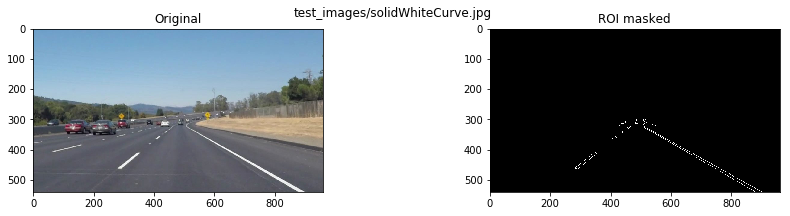

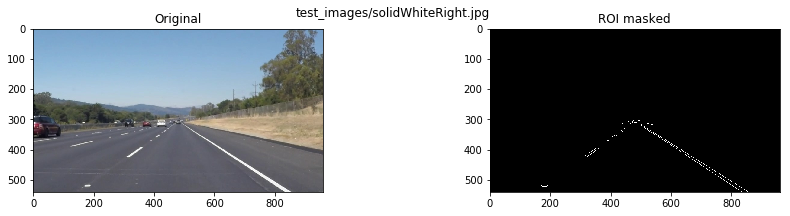

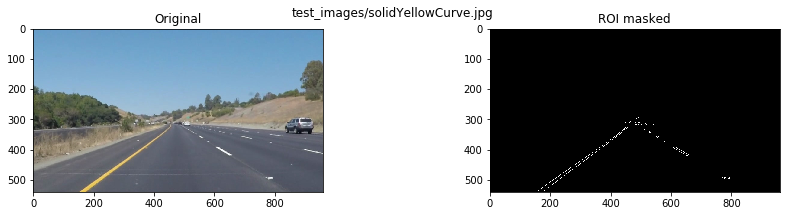

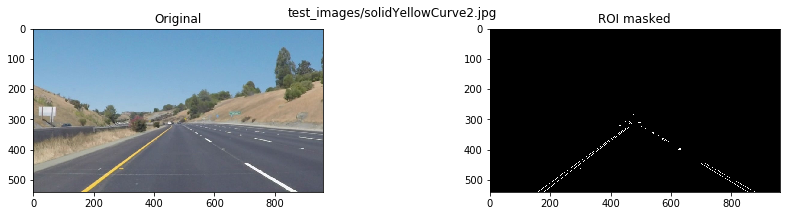

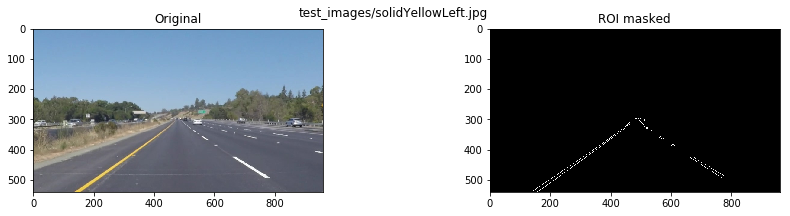

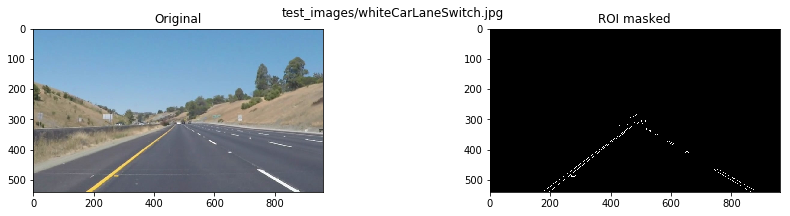

In [71]:
def inspect_roi_plot(img_path, vertices, kernel_size=5, low_threshold=100, high_threshold=200):
    fig = plt.figure(figsize=(15,3))
    fig.suptitle(img_path, fontsize=12)
    
    col = 2
    row = 1
    count = 0
    
    img = cv2.imread(img_path)
    canny_img = get_canny_edge(img, kernel_size, low_threshold, high_threshold)
    roi_img = region_of_interest(canny_img, [vertices])
    
    # Plot the result
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('ROI masked')
    plt.imshow(roi_img, cmap='gray')

# Parameters for Region of Interest
left_bottom = [130, 539]
right_bottom = [920, 539]
apex = [480, 280]

x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]

vertices = np.array([left_bottom, right_bottom, apex])

img_files = os.listdir(folder_name)

for file in img_files:
    path = folder_name + file
    inspect_roi_plot(path, vertices, kernel_size, low_threshold, high_threshold)


Pretty clean result for ROI

#### Hough Lines
Let's overlay the high line result on the original and see

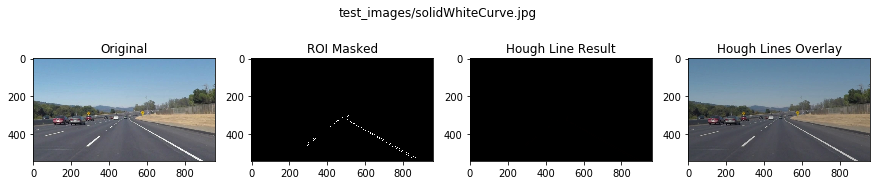

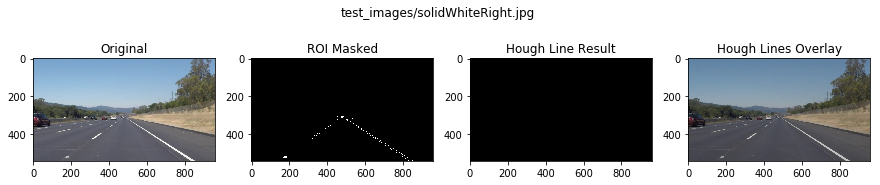

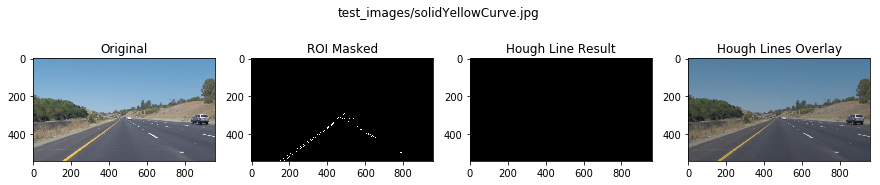

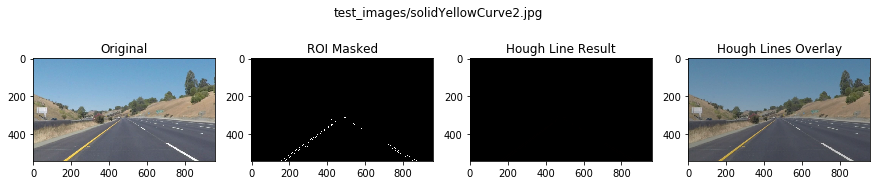

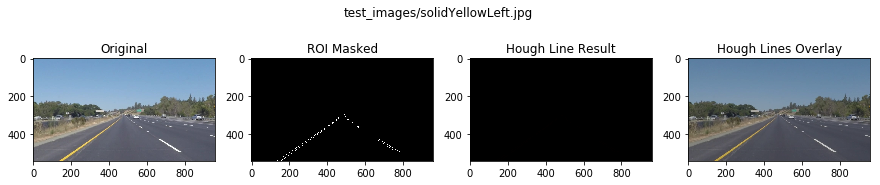

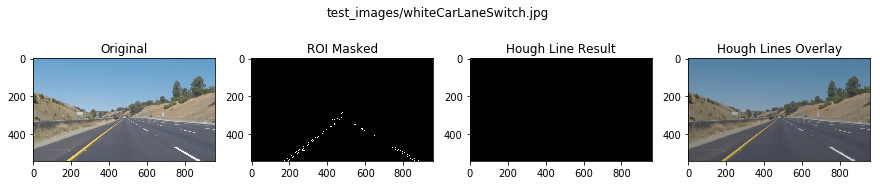

In [91]:
# Redefine functions for easier debug
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, thickness=2):
    # input img should always be the output of canny transform
    # return an image with hough lines drawn
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_drawn_img = draw_lines(line_img, lines, thickness)
    return line_drawn_img

def draw_lines(img, lines, color=[255,0,0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    return img

def inspect_hough_lines_plot(img_path):
    # Read image
    img = cv2.imread(img_path)
    
    # Process it
    canny_img = get_canny_edge(img, kernel_size, low_threshold, high_threshold)
    roi_img = region_of_interest(canny_img, [vertices])
    hough_lines_img = hough_lines(roi_img,rho,theta,threshold,min_line_length,max_line_gap)
    
    # Overlay the result
    overlay_img = weighted_img(hough_lines_img, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    fig = plt.figure(figsize=(15,3))
    fig.suptitle(img_path, fontsize=12)
    
    col = 4
    row = 1
    count = 0
    
    # Plot the result
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    count += 1
    fig.add_subplot(row, col, count)
    plt.title('ROI Masked')
    plt.imshow(roi_img, cmap='gray')

    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Hough Line Result')
    plt.imshow(hough_lines_img)
    
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Hough Lines Overlay')
    plt.imshow(overlay_img)

    
# Hough Lines Parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
        
for file in img_files:
    path = folder_name + file
    inspect_hough_lines_plot(path)